In [1]:
import sys
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import random as python_random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(40) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(40)



#### Questions:
# How does tf (under this method) store labels? Can I access them?
#    Look into how the resizing line is done
# What happens if I don't pass the y value into imageDataGenerator().flow()?
# is this enough work? (oversampling, data augmentation, adusting the prediction wieghts)
# multiple expert -  3 different model (majority voting at the end to make predictions) - cost trade off for computing
# - talk about costs (training time, different work, etc)
# - accuracy vs tradeoffs (latency of making one prediction)

In [2]:
!ls ../HOLD_data/

Covid_img  Normal_img  Viral_img


# Load the Data

In [3]:
HOLD_dir = '../HOLD_data/'
test_dir = '../dl_data/'
class_names = os.listdir(HOLD_dir)

batch_size = 8;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 244; 
img_width = 244;

img_height_dense = 224; 
img_width_dense = 224;

# Test Dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 40,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Holdout Dataset
HOLD_ds = tf.keras.preprocessing.image_dataset_from_directory(
    HOLD_dir,
    seed = 40,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Test Dataset DENSE
test_ds_dense = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 40,
    image_size= (img_height_dense, img_width_dense),
    batch_size = batch_size
)

# Holdout Dataset DENSE
HOLD_ds_dense = tf.keras.preprocessing.image_dataset_from_directory(
    HOLD_dir,
    seed = 40,
    image_size= (img_height_dense, img_width_dense),
    batch_size = batch_size
)

Found 13638 files belonging to 3 classes.
Using 2727 files for validation.


2022-04-27 01:45:32.166098: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 01:45:33.969878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38397 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:b7:00.0, compute capability: 8.0


Found 1514 files belonging to 3 classes.
Found 13638 files belonging to 3 classes.
Using 2727 files for validation.
Found 1514 files belonging to 3 classes.


# Functions

In [4]:
thresh_range = [(x/10000) for x in range(0,10000)]

def pr_curve(predictions, labels, save_path=None, save_period=None):
    # for each threshold value calculate precision and recal
    results = pd.DataFrame(columns=['threshold', 'precision', 'recall', 'sensativity'])
    for i, t in enumerate(thresh_range):
        th, pr, rc, sen = calc_prec_recall(t,predictions, labels)
        results = pd.concat([results,pd.DataFrame.from_dict({'threshold': [th],'precision': [pr],'recall': [rc], 'sensativity': [sen]})])
        if(save_period is not None and i%save_period == 0): # saves periodically
            results.to_csv(save_path, index=False)
            
    if(save_path is not None): # save at the end
        results.to_csv(save_path, index=False)
    return(results)
    

def building_blocks(threshold_value, predictions, labels):
    # for this function we will consolidate classes
    # we only want to compare the target class to the non-target class
    # Covid_img is our target class (true values) and  Normal_img  Viral_img are our other classes (false values)
    # class 0 indicates Covid
    
    pos = 0
    neg = 0
    tp = 0 # true positive
    fp = 0 # false positive
    tn = 0 # true negative
    fn = 0 # false negative
    for i, p in enumerate(predictions):
        if p[0] > threshold_value: # positive
            if labels[i] == 0: # positive
                pos += 1
                tp += 1
            else: # negative
                neg += 1
                fp += 1
        else: # negative
            if labels[i] == 0: # positive
                pos += 1
                fn += 1
            else: # negative
                neg += 1
                tn += 1

    return(threshold_value, tp, fp, tn, fn, pos, neg)

def calc_prec_recall(threshold_value ,predictions, labels):
    threshold, tp, fp, tn, fn, p, n = building_blocks(threshold_value, predictions, labels)
    
    # precision
    precision = tp/(tp + fp + 0.000000000001)
    
    # recall aka sensativity
    recall = tp/p
    
    # specificity
    specificity = tn/n
    
    return(threshold, precision, recall, specificity)

def adj_class(arr, threshold):
    new_pred = []
    for a in arr:
        if(a[0]>threshold):
            new_pred = np.append(new_pred,0)
        else:
            new_pred = np.append(new_pred,np.argmax(a[0]))
    return(new_pred)

# Model 1: Resnet

### 1. Find the ideal Threshold
We want to select a threshold that maximizes COVID-19 true positives and minimizes false negatives. To find the threshold we need to do this on test data.

In [5]:
# load model

# rn_model has class weighting in the training, model_RECALL does not
saved_model_1 = tf.keras.models.load_model('./saved_models/model_ROUND3_part2')
predictions_1 = saved_model_1.predict(test_ds)#, batch_size=batch_size)

2022-04-27 01:45:44.249126: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-04-27 01:45:49.070345: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [6]:
# saved_model_1.predict_classes()
predictions_1

array([[1.1811524e-11, 9.9999988e-01, 1.7791467e-07],
       [7.0402342e-01, 2.9587495e-01, 1.0159946e-04],
       [1.2211216e-06, 8.0269313e-01, 1.9730560e-01],
       ...,
       [7.1645282e-08, 9.9999964e-01, 1.9465291e-07],
       [8.3543215e-05, 9.9984813e-01, 6.8289526e-05],
       [1.2807837e-06, 4.3817820e-08, 9.9999869e-01]], dtype=float32)

In [31]:
# list(np.argmax(predictions_1, axis=1))

In [19]:
np.sum(predictions_1, axis=0)

array([ 757.7886, 1620.2302,  348.98  ], dtype=float32)

In [20]:
# pull in label values
y_true = []
for img, label in test_ds:
    y_true.append(label.numpy())

In [21]:
# calculate precision and recall
results_1 = pr_curve(predictions_1, np.concatenate(y_true), save_path='results/model_1.csv', save_period=100)

In [22]:
# select the right threshold
# we want max precision
results_1.sort_values(['precision','recall'], ascending=False).to_csv('./thresholds_1.csv')

In [25]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(y_true, predictions_1, name="LinearSVC")
_ = display.ax_.set_title("2-class Precision-Recall curve")

ValueError: Found input variables with inconsistent numbers of samples: [341, 2727]

### 2. After finding an ideal threshold, we assign any class that's over the threshold for COVID-19 to the COVID class

In [28]:
# before or after combining predictions, set threshold for predictions and assign to classes based on that threshold
threshold_1 = .9079 # threshold should be determined on test data not holdout

threshold_1 = .50

adj_pred_1 = adj_class(predictions_1, threshold_1)

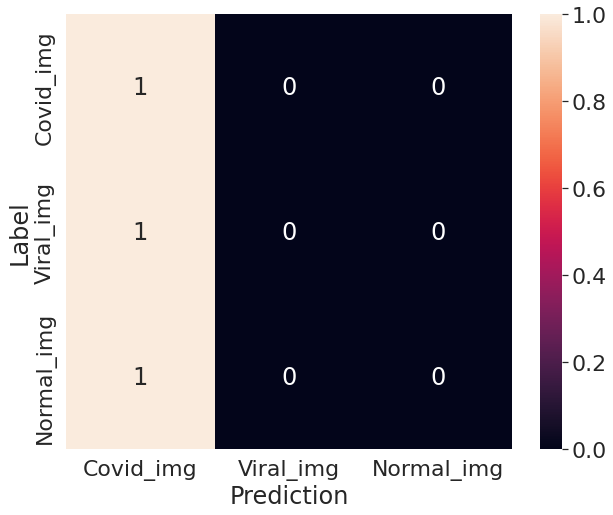

In [29]:
y_true = []
for img, label in test_ds:
    y_true.append(label.numpy())
y_true

# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    adj_pred_1,
    num_classes=3,
    weights=None)
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix1.png')
plt.show()

In [ ]:
TEST ON HOLDOUT

# Model 2: VGGNet

### 1. Find the ideal Threshold
We want to select a threshold that maximizes COVID-19 true positives and minimizes false negatives. To find the threshold we need to do this on test data.

In [ ]:
# load model
saved_model_2 = tf.keras.models.load_model('./saved_models/model_VGG')
predictions_2 = saved_model_2.predict(test_ds)

In [ ]:
predictions_2

In [ ]:
np.sum(predictions_2, axis=0)

In [ ]:
# pull in label values
y_true = []
for img, label in test_ds:
    y_true.append(label.numpy())

In [ ]:
# calculate precision and recall
results_2 = pr_curve(predictions_2, np.concatenate(y_true), save_path='results/model_2.csv', save_period=100)

In [ ]:
# select the right threshold
# we want max precision
results_2.sort_values(['precision','recall'], ascending=False).to_csv('./thresholds_2.csv')

### 2. After finding an ideal threshold, we assign any class that's over the threshold for COVID-19 to the COVID class

In [23]:
# before or after combining predictions, set threshold for predictions and assign to classes based on that threshold
threshold_2 = 0.64 # threshold should be determined on test data not holdout

adj_pred_2 = adj_class(predictions_2, threshold_2)

In [24]:
y_true = []
for img, label in test_ds:
    y_true.append(label.numpy())
y_true

# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    np.argmax(adj_pred_2, axis=1),
    num_classes=3,
    weights=None)
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix2.png')
plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

# Model 3: DenseNet

### 1. Find the ideal Threshold
We want to select a threshold that maximizes COVID-19 true positives and minimizes false negatives. To find the threshold we need to do this on test data.

In [ ]:
# load model
saved_model_3 = tf.keras.models.load_model('./saved_models/model_Dense')
predictions_3 = saved_model_3.predict(test_ds_dense)

In [ ]:
predictions_3

In [ ]:
np.sum(predictions_3, axis=0)

In [ ]:
# pull in label values
y_true = []
for img, label in test_ds_dense:
    y_true.append(label.numpy())

In [ ]:
# calculate precision and recall
results_3 = pr_curve(predictions_3, np.concatenate(y_true), save_path='results/model_3.csv', save_period=100)

In [ ]:
# select the right threshold
# we want max precision
results_3.sort_values(['precision','recall'], ascending=False)#.to_csv('./thresholds_3.csv')

### 2. After finding an ideal threshold, we assign any class that's over the threshold for COVID-19 to the COVID class

In [ ]:
# before or after combining predictions, set threshold for predictions and assign to classes based on that threshold
threshold_3 = 0.64 # threshold should be determined on test data not holdout

adj_pred_3 = adj_class(predictions_3, threshold_3)

In [ ]:
# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    np.argmax(adj_pred_3, axis=1),
    num_classes=3,
    weights=None)
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix2.png')
plt.show()

# Combine the predictions

In [ ]:
# Prediction on holdout data, now that we have the threshold selected

HOLD_predictions_1 = saved_model_1.predict(HOLD_ds)
HOLD_predictions_2 = saved_model_2.predict(HOLD_ds)
HOLD_predictions_3 = saved_model_3.predict(HOLD_ds_dense)

In [ ]:
HOLD_adj_pred_1 = adj_class(HOLD_predictions_1, threshold_1)
HOLD_adj_pred_2 = adj_class(HOLD_predictions_2, threshold_2)
HOLD_adj_pred_3 = adj_class(HOLD_predictions_3, threshold_3)

max_pred

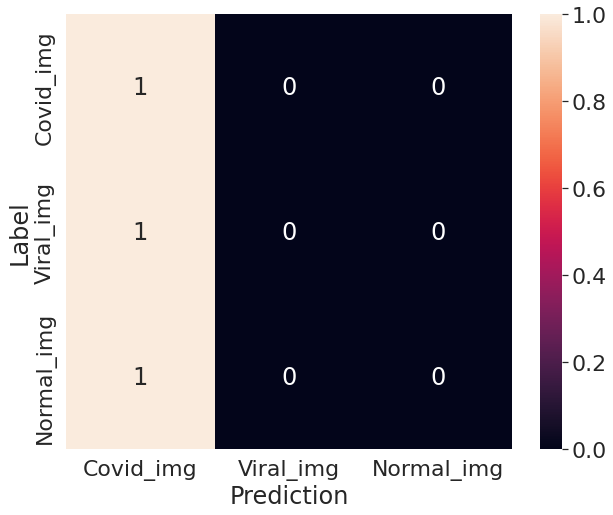

In [20]:
y_true = []
for img, label in test_ds:
    y_true.append(label.numpy())
y_true


# create and plot confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.concatenate(y_true),
    np.argmax(max_pred, axis=1),
    num_classes=3,
    weights=None) # change to get to 100% covid accuracy
confusion_mtx = confusion_mtx/confusion_mtx.numpy().sum(axis=1)[:, tf.newaxis]
plt.figure(figsize=(10, 8))
sns.set(font_scale = 2)
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('matrix2.png')
plt.show()